<a href="https://colab.research.google.com/github/RicardoBNR/Proyecto_IA_03/blob/main/Proyecto_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression


#Cargamos el dataset

df = pd.read_csv('language_detection.csv')

print(df.head(5))

print("\n ================================================== \n")


#Revisamos la distribución de texto por idioma
print(df["language"].value_counts())

                                                Text  language
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian
1  sebes joseph pereira thomas  på eng the jesuit...   Swedish
2  ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...      Thai
3  விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...     Tamil
4  de spons behoort tot het geslacht haliclona en...     Dutch


language
Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: count, dtype: int64


In [92]:
#Para algunos modelos la variable categorica debe de ser un número
claves = {
0: "Estonian",
1: "Swedish",
2: "Thai",
3: "Tamil",
4: "Dutch",
5: "Japanese",
6: "Turkish",
7: "Latin",
8: "Urdu",
9: "Indonesia",
10: "Portugese",
11: "French",
12: "Chinese",
13: "Korean",
14: "Hindi",
15: "Spanish",
16: "Pushto",
17: "Persian",
18: "Romanian",
19: "Russian",
20: "English",
21: "Arabic" }

In [119]:
df['code'] = pd.factorize(df['language'])[0]

In [121]:
exp = df.groupby("code")
print(exp.head())

                                                  Text  language  code
0    klement gottwaldi surnukeha palsameeriti ning ...  Estonian     0
1    sebes joseph pereira thomas  på eng the jesuit...   Swedish     1
2    ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...      Thai     2
3    விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...     Tamil     3
4    de spons behoort tot het geslacht haliclona en...     Dutch     4
..                                                 ...       ...   ...
191  ally y buttons encuentran el descodificador y ...   Spanish    15
195  los primeros habitantes se establecieron cerca...   Spanish    15
196  în  albania a devenit regat sub conducerea reg...  Romanian    18
227  历史上的柔远驿是为了给琉球贡使及随员提供食宿之所，同时它也成为中琉间商业和文化交流的枢纽。琉...   Chinese    12
228  un grup de cercetași din rondul de noapte porn...  Romanian    18

[110 rows x 3 columns]


En el caso específico de CountVectorizer, tiene la capacidad de eliminar las stopwords, pero sólo de un lenguaje a la vez, por lo que no lo vamos a utilizar, además de que en este caso las preposiciones nos podrían dar información relevante del lenguaje y que para algunos lenguajes, quitar sus stopwords sería complicado.


Si limitamos las features, corremos el riesgo de eliminar completamente la información de algún lenguaje completo.






In [94]:
#Creamos el vectorizador
X_CountVectorizer = CountVectorizer()
X_TfidfTransformer = TfidfTransformer()

Primero vamos a intentar visualizar el dataset, por lo que tomaremos una muestra de 30 elementos por lenguaje para poder ver cómo se distribuyen los datos

In [95]:
sample = df.groupby("language").sample(n=30, random_state=42).reset_index()


In [96]:
texto_counts = X_CountVectorizer.fit_transform(sample.Text)
tfidf_vectors = X_TfidfTransformer.fit_transform(texto_counts)

In [97]:
#Utilizamos svd para visualizar los datos
svd = TruncatedSVD(n_components=2)
reduced_matrix =  svd.fit_transform(tfidf_vectors)
principalDf = pd.DataFrame(data = reduced_matrix, columns = ['svd1', 'svd2'])


       svd1      svd2 language
0  0.000021  0.000841   Arabic
1  0.000334  0.002132   Arabic
2  0.000043  0.001666   Arabic
3  0.000018  0.000731   Arabic
4  0.000030  0.001123   Arabic


Text(0, 0.5, 'SVD 2')

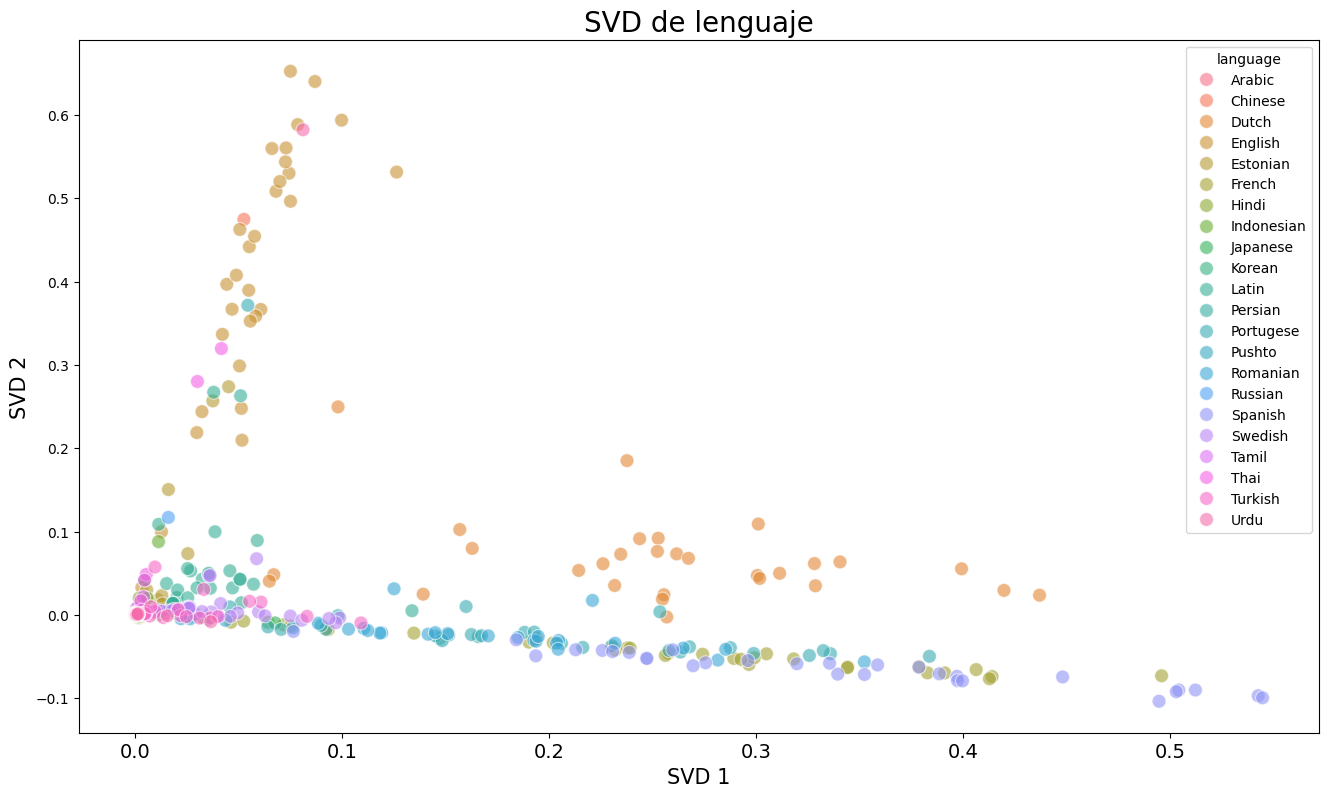

In [98]:
finalDf = pd.concat([principalDf, sample.language], axis = 1)
print(finalDf.head())

#Creamos el plot
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "svd1", y = "svd2", data = finalDf, hue = "language", alpha = 0.6, s = 100);
plt.title('SVD de lenguaje', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("SVD 1", fontsize = 15)
plt.ylabel("SVD 2", fontsize = 15)

-- Interpretacion

In [99]:
#Separmos los datos en prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(df.Text,
                                                    df.language,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    shuffle=True)



X_train_counts = X_CountVectorizer.fit_transform(X_train)
X_train_tfidf = X_TfidfTransformer.fit_transform(X_train_counts)

X_test_counts = X_CountVectorizer.transform(X_test)
X_test_tfidf = X_TfidfTransformer.transform(X_test_counts)



In [100]:
#Primero modelo, Naive Bayes
model = MultinomialNB()

model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

#Evaluación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00       249
     Chinese       0.95      0.50      0.65       254
       Dutch       0.99      0.98      0.98       268
     English       0.69      1.00      0.81       239
    Estonian       0.99      0.96      0.98       248
      French       0.93      0.99      0.96       239
       Hindi       1.00      0.98      0.99       264
  Indonesian       0.98      0.98      0.98       258
    Japanese       0.98      0.62      0.76       250
      Korean       1.00      0.98      0.99       246
       Latin       0.99      0.90      0.94       260
     Persian       1.00      1.00      1.00       242
   Portugese       1.00      0.96      0.98       256
      Pushto       1.00      0.97      0.98       255
    Romanian       0.98      0.98      0.98       247
     Russian       0.98      0.99      0.99       249
     Spanish       0.97      1.00      0.98       238
     Swedish       0.60    

-- Comentar acerca de los resultados

In [101]:
#Código para obtener las predicciones, como viene de un dataframe
#Al utilizar test y split para comparar se tienen que recuperar
#el valor de la etiqueta, por lo que hay que hacer un Join usando su index
get_code = pd.merge(y_train, df, left_index=True, right_index=True)
codes_y_train  = get_code["code"]

get_code_test = pd.merge(X_test, df, left_index=True, right_index=True)
codes_y_test  = get_code_test["code"]


In [102]:
# Implementación del segundo modelo
# Multinomial porque son 21 etiquetas
regr = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
regr.fit(X_train_tfidf, codes_y_train)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


LogisticRegression(C=50.0, multi_class='multinomial', n_jobs=4, random_state=17)

In [103]:
y_pred = regr.predict(X_test_tfidf)

-- Comentar acerca de los resultados

In [104]:
print(classification_report(codes_y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       248
           1       1.00      1.00      1.00       229
           2       1.00      0.98      0.99       250
           3       1.00      0.99      0.99       253
           4       1.00      0.99      0.99       268
           5       0.93      0.65      0.76       250
           6       0.99      0.99      0.99       246
           7       0.96      0.94      0.95       260
           8       1.00      0.98      0.99       260
           9       0.99      0.98      0.98       258
          10       0.99      0.99      0.99       256
          11       0.96      0.98      0.97       239
          12       0.69      0.94      0.80       254
          13       1.00      0.98      0.99       246
          14       1.00      0.98      0.99       264
          15       0.99      0.98      0.99       238
          16       1.00      0.97      0.98       255
          17       1.00    

In [125]:
def predice(texto):

  text = [texto]
  text_counts = X_CountVectorizer.transform(text)
  text_tfidf = X_TfidfTransformer.transform(text_counts)


  prediction1 = model.predict(text_tfidf)
  prediction2 = regr.predict(text_counts)

  print(prediction2)
  print([prediction1[0],claves[prediction2[0]]])


In [128]:


text = "Buenos días"
predice(text)



[12]
['Spanish', 'Chinese']
